![MLU Logo](../data/MLU_Logo.png)

# <a name="0">Machine Learning Accelerator - Computer Vision - Lecture 2</a>


## Fine-Tuning with Pre-trained AlexNet 

In this notebook, we use a pre-trained [AlexNet](https://d2l.ai/chapter_convolutional-modern/alexnet.html) on the [MINC](http://opensurfaces.cs.cornell.edu/publications/minc/)  dataset. This notebook is similar to our previous notebook `MLA-CV-DAY1-CNN.ipynb`, so we may skip some details to be concise. We will cover the following topics:

1. <a href="#1">Loading and Transforming Dataset</a>      
2. <a href="#2">Fine-tuning Pretrained AlexNet</a>
3. <a href="#3">Testing and Visualizations</a>


First, let's update torch at least to v1.6.0 and d2l to v0.15.0

In [1]:
%%capture
!pip install -q -r ../requirements.txt

Now let's import the necessary libraries.

In [2]:
import os
import torch
import torchvision
from torch import nn
from torchvision import transforms
import numpy as np

## 1. <a name="1">Loading and Transforming Dataset</a>
(<a href="#0">Go to top</a>)

To load the dataset properly, we need to massage the image data a bit by some `transforms` functions. PyTorch provides a full list of [transforms functions](https://pytorch.org/docs/stable/torchvision/transforms.html) to enable a wide variety of data augmentation. 

We will process some simple data transformations in this example. First, we load the image data and resize it to the given size (224,224). Next, we convert the image tensor of shape (H x W x C) in the range [0, 255] to a float32 tensor of shape (C x H x W) in the range (0, 1) using the `ToTensor` class. Last, we normalize the tensor of shape (C x H x W) with its mean and standard deviation by `Normalize`.

In [3]:
transform_train = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0,0,0), std=(1,1,1))
])

transform_test = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0,0,0), std=(1,1,1))
])

Now apply the predefined transform functions and load the train, validation and test sets.

In practice, reading data can be a significant performance bottleneck, especially when our model is simple or when our computer is fast. To make our life easier when reading from the datasets, we use a `DataLoader` of Gluon, which reads a minibatch of data with size `batch_size` each time.

In [4]:
batch_size = 16

path = '../data/minc-2500'
train_path = os.path.join(path, 'train')
val_path = os.path.join(path, 'val')
test_path = os.path.join(path, 'test')

train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.ImageFolder(train_path, transform=transform_train),
    batch_size=batch_size, shuffle=True)

validation_loader = torch.utils.data.DataLoader(
    torchvision.datasets.ImageFolder(val_path, transform=transform_test),
    batch_size=batch_size, shuffle=False)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.ImageFolder(test_path, transform=transform_test),
    batch_size=batch_size, shuffle=False)

## 2. <a name="2">Fine-tuning Pretrained AlexNet</a>
(<a href="#0">Go to top</a>)

To fine-tune a pretrained model, we need the following 4 steps:
1. Define a neural network **finetune_net** with AlexNet architecture, and later reshape for given number of output classes. Note that for `torchvision.models.alexnet` the default parameter `pretrained` is False, which means it will only return us an AlexNet architecture rather than an AlexNet architecture with the pretrained weights.

1. Initialize the **finetune_net** with [Xavier initialization](https://d2l.ai/chapter_multilayer-perceptrons/numerical-stability-and-init.html#xavier-initialization) to make sure our random initialized weights are neither too small nor too huge.

1. Define another neural network, **pretrained_net**, and load the pretrained AlexNet model (which was trained on ImageNet) on it. Here, by specifying ``pretrained=True``, it will automatically download the model from torchvision model zoo if necessary. For more pretrained models, please refer to [torchvision Models](https://pytorch.org/docs/stable/torchvision/models.html).

1. Transfer the trained weights (except last layer) from **pretrained_net** to **finetune_net**, and output **finetune_net**.

In [13]:
feature_extract = True
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

def FineTuneAlexnet(classes, device):
    '''
    classes: number of the output classes 
    device: training context (CPU or GPU)
    '''
    from torchvision.models import AlexNet_Weights
    finetune_net = torchvision.models.alexnet(weights=AlexNet_Weights.IMAGENET1K_V1).to(device)
    set_parameter_requires_grad(finetune_net, feature_extract)
    num_ftrs = finetune_net.classifier[6].in_features
    finetune_net.classifier[6] = nn.Linear(num_ftrs, classes)
    
    return finetune_net

Let's create a `net` using the `FineTuneAlexnet` on available GPUs (or CPUs) by defining the training context `ctx`. Since the MINC dataset has 6 categories, the output classes will be 6.

In [14]:
device = "cpu" # Create neural net on CPU or GPU depending on your training instances
num_outputs = 6        # 6 output classes
net = FineTuneAlexnet(num_outputs, device)

net

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

Next, we set up the hyperparameters for training, such as the learning rate of optimization algorithms. With the defined learning rate, we are able to create an `Optimizer` to infer the neural network "how to optimize its weights".

In [15]:
learning_rate = 0.001

#  We will only update the parameters that we have just initialized,
#  i.e. the parameters with requires_grad is True.
params_to_update = net.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in net.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

optimizer = torch.optim.SGD(params_to_update, lr=learning_rate)

Params to learn:
	 classifier.6.weight
	 classifier.6.bias


Besides, we need to specify the loss function. Since this problem is a multiclass classification task, we will use softmax as our loss funciton.

In [16]:
criterion = nn.CrossEntropyLoss()

Our network is almost ready to be finetuned! One last thing before the finetuning is to define the `accuracy` function for evulating our model.

In [17]:
def finetune_accuracy(output, label):
    # output: (batch, num_output) float32 tensor
    # label: (batch, ) int32 tensor
    return (output.argmax(axis=1) == label.float()).float().mean()

Now it's the training time! Starting with the outer loop, we will have 10 epochs (10 full pass through our dataset). Within the inner loop, we yield each mini-batch from the `train_loader`, and update the weights based on the average statistics of this mini-batch.

In [18]:
epochs = 10

for epoch in range(epochs):
    net = net.to(device)
    train_loss, val_loss, train_acc, valid_acc = 0., 0., 0., 0.
    
    # Training loop: (with autograd and trainer steps, etc.)
    # This loop does the training of the neural network (weights are updated)
    net.train()
    for i, (data, label) in enumerate(train_loader):
        # zero the parameter gradients
        optimizer.zero_grad()
        data = data.to(device)
        label = label.to(device)
        output = net(data)
        loss = criterion(output, label)
        loss.backward()
        train_acc += finetune_accuracy(output, label)
        train_loss += loss
        optimizer.step()
    
    # Validation loop:
    # This loop tests the trained network on validation dataset
    # No weight updates here
    net.eval()
    for i, (data, label) in enumerate(validation_loader):
        data = data.to(device)
        label = label.to(device)
        output = net(data)
        valid_acc += finetune_accuracy(output, label)
        val_loss += criterion(output, label)
        
    # Take averages
    train_loss /= len(train_loader)
    train_acc /= len(train_loader)
    val_loss /= len(validation_loader)
    valid_acc /= len(validation_loader)
    
    print("Epoch %d: train loss %.3f, train acc %.3f, val loss %.3f, val acc %.3f" % (
        epoch+1, train_loss.detach().cpu().numpy(), train_acc.detach().cpu().numpy(),
        val_loss.detach().cpu().numpy(), valid_acc.detach().cpu().numpy()))

Epoch 1: train loss 1.216, train acc 0.602, val loss 0.853, val acc 0.786
Epoch 2: train loss 0.810, train acc 0.762, val loss 0.684, val acc 0.818
Epoch 3: train loss 0.698, train acc 0.773, val loss 0.619, val acc 0.828
Epoch 4: train loss 0.630, train acc 0.801, val loss 0.586, val acc 0.828
Epoch 5: train loss 0.592, train acc 0.801, val loss 0.559, val acc 0.849
Epoch 6: train loss 0.564, train acc 0.815, val loss 0.546, val acc 0.849
Epoch 7: train loss 0.548, train acc 0.816, val loss 0.534, val acc 0.839
Epoch 8: train loss 0.522, train acc 0.835, val loss 0.517, val acc 0.854
Epoch 9: train loss 0.502, train acc 0.834, val loss 0.508, val acc 0.859
Epoch 10: train loss 0.496, train acc 0.833, val loss 0.511, val acc 0.839


If you would like to save the trained model, no matter using it for inference or to retrain it later. You can call `save_parameters` function to save the model architecture and its weights.

In [19]:
torch.save(net.state_dict(), "my_model")

## 3. <a name="3">Testing and Visualizations</a>
(<a href="#0">Go to top</a>)

Let's validate our model predictions. Meanwhile, we use the `show_images` function and show the sample images and its prediction together.

In [22]:
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):
    from matplotlib import pyplot as plt
    """Plot a list of images."""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        ax.imshow(img.permute(1,2,0).numpy())
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

tensor([0, 0, 1, 5, 5, 0, 4, 4, 5, 5, 2, 2, 3, 3, 3, 3])


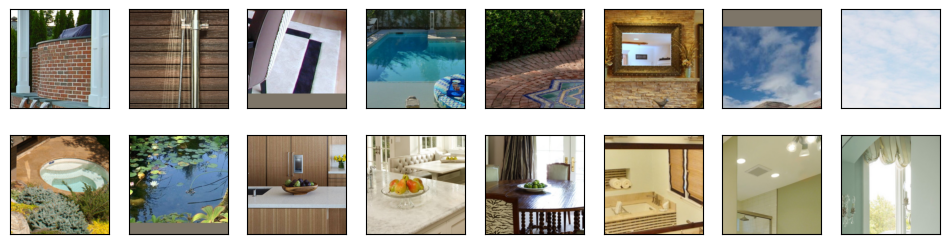

In [23]:
random_test_dataset = torchvision.datasets.ImageFolder(test_path,
                                                       transform=transform_test)
random_test_sample = torch.utils.data.DataLoader(random_test_dataset,
                                                 batch_size=2*8, shuffle=True)

net.eval()
for data, label in random_test_sample:
    show_images(data, 2, 8);
    data = data.to(device)
    pred = net(data)
    print(pred.argmax(axis=1))
    break